# **0. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi

Sat Nov 23 15:00:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **1. Connexion à la plateforme Wandb** ##

Weights and Biases (W&B) est une plateforme qui permet de suivre, visualiser et partager les résultats d'expériences en temps réel. Cela permet de faciliter le tracking des expériences. Veuillez Créer vous un compte en allant sur le lien [https://wandb.ai/site](https://wandb.ai/site)

In [2]:
!pip install wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **2.1. Importation des libraries** ##



In [3]:
import os
import numpy as np
import torch
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import cv2
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from tqdm import tqdm
import wandb
!pip install pytorch_lightning
from torchmetrics import Accuracy
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger , CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image

from torch.optim.lr_scheduler import ReduceLROnPlateau


from torchmetrics.classification import MulticlassConfusionMatrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 46.6 MB/s eta 0:00:00


# **2.2 Installation de libraririe "benchamrk" pour évaluer les résultats en détail** ##

In [4]:
!pip install pytorch_bench
from pytorch_bench import benchmark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.2/504.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 2.5.0
    Uninstalling termcolor-2.5.0:
      Successfully uninstalled termcolor-2.5.0
  Attempting uninstall: prompt_toolkit
    Found existing installation: prompt_toolkit 3.0.48
    Uninstalling prompt_toolkit-3.0.48:
      Successfully uninstalled prompt_toolkit-3.0.48
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
i

Benchmark : librarire développée au sein de l'équipe Deep'ILIA (Service ILIA-FPMS) dans le cadre de la thèse de doctorat de Maxime Gloesener.

# **3.1.1 Téléchargement du jeu de données d'entraînement** ##


In [ ]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
!mkdir -p FIRE/train
!unzip small.zip -d FIRE/train
!rm small.zip

In [ ]:
# DB1 : https://nextcloud.ig.umons.ac.be/s/REWbK6K4XRtoeNw/download/FIRE_DATABASE_1.zip
# DB2 : https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_2.zip
# DB3 : https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_3.zip

# **3.1.2 Pour une base de données que j'importe dans Google Colab** ##

In [5]:
!rm -rf sample_data
!mkdir -p FIRE/train
!unzip Total.zip -d FIRE/train
!rm Total.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: FIRE/train/TOTAL_2/fire/WEB10749.jpg  
  inflating: FIRE/train/__MACOSX/TOTAL_2/fire/._WEB10749.jpg  
  inflating: FIRE/train/TOTAL_2/fire/00000046.jpg  
  inflating: FIRE/train/__MACOSX/TOTAL_2/fire/._00000046.jpg  
  inflating: FIRE/train/TOTAL_2/fire/518.jpg  
  inflating: FIRE/train/__MACOSX/TOTAL_2/fire/._518.jpg  
  inflating: FIRE/train/TOTAL_2/fire/images - 2022-05-04T104029.512.jpeg  
  inflating: FIRE/train/__MACOSX/TOTAL_2/fire/._images - 2022-05-04T104029.512.jpeg  
  inflating: FIRE/train/TOTAL_2/fire/530.jpg  
  inflating: FIRE/train/__MACOSX/TOTAL_2/fire/._530.jpg  
  inflating: FIRE/train/TOTAL_2/fire/images - 2022-05-04T104020.501.jpeg  
  inflating: FIRE/train/__MACOSX/TOTAL_2/fire/._images - 2022-05-04T104020.501.jpeg  
  inflating: FIRE/train/TOTAL_2/fire/00000091.jpg  
  inflating: FIRE/train/__MACOSX/TOTAL_2/fire/._00000091.jpg  
  inflating: FIRE/train/TOTAL_2/fire/WEB10952

# **3.2. Téléchargement du jeu de données de test** ##

In [6]:
!wget https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip
!unzip test.zip -d FIRE/test
!rm test.zip

--2024-11-23 15:02:40--  https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  11.7MB/s    in 5.5s    

2024-11-23 15:02:47 (9.91 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: FIRE/test/test/
   creating: FIRE/test/test/fire/
  inflating: FIRE/test/test/fire/F_1001.jpg  
  inflating: FIRE/test/test/fire/F_2062.jpg  
  inflating: FIRE/test/test/fire/F_2063.jpg  
  inflating: FIRE/test/test/fire/F_2064.jpg  
  inflating: FIRE/test/test/fire/F_2066.jpg  
  inflating: FIRE/test/test/fire/F_2067.jpg  
  inflating: FIRE/test/test/fire/F_2068.jpg  
  inflating: FIRE/test/test/fire/F_2070.jpg  
  inflatin

#**4. Paramètres d'entrainement "Hyper-paramètres"**

In [7]:
Train_data_path = "Total" #@param ["small","DB1","DB2","DB3", "Total"]
Train_data_path = os.path.join('FIRE/train', Train_data_path)
Test_data_path = "test" #@param ["test","test_defi1"]
Test_data_path = os.path.join('FIRE/test', Test_data_path)
Batch_size=16 #@param [8,16,32,64,128,256] {type:"raw"}
Epochs=25 #@param [1,5, 10,20,25,50,100,200] {type:"raw"}
Learning_rate = 0.01 #@param [0.1, 0.01,0.02,0.05,0.001,0.002,0.005] {type:"raw"}
Train_split = 0.8 #@param [0.7,0.8,0.9] {type:"raw"}
Img_size = 224 #@param [224,299] {type:"raw"}
Accelerator= "auto" #@param ["cpu","gpu","auto"]
num_classes = 3
LOG_DIR="logs/"

#**5.1.Télécharger modèle préentrainé VGG16 & afficher l'architecture (A COMPLETER)**

In [8]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16.classifier = nn.Sequential(
    nn.Linear(vgg16.classifier[0].in_features, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, num_classes)  # Dernière couche pour le nombre de classes
)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
MODEL_NAME = "resnet152" #@param ['vgg16', 'resnet152', 'efficientnet_v2_l', 'googlenet']

# **5.2. Définir modèle, param Forward/Backward & Transfer Leraning (A COMPLETER)** ##

In [10]:
class FireDetectionModel(pl.LightningModule):
    def __init__(self, model_name='vgg16', num_classes=3, learning_rate=1e-3):
        super().__init__()

        if model_name == 'vgg16':
            self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            self.model.classifier = nn.Sequential(
              nn.Linear(self.model.classifier[0].in_features, 4096),
              nn.ReLU(),
              nn.Dropout(p=0.5),
              nn.Linear(4096, 4096),
              nn.ReLU(),
              nn.Dropout(p=0.5),
              nn.Linear(4096, num_classes)  # Dernière couche pour le nombre de classes
            )

        elif model_name == 'resnet152':
          self.model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
          self.model.fc = nn.Sequential(
              nn.Linear(self.model.fc.in_features, 4096),  # Première fully connected
              nn.ReLU(),
              nn.Dropout(p=0.25),
              nn.Linear(4096, 4096),  # Deuxième fully connected
              nn.ReLU(),
              nn.Dropout(p=0.25),
              nn.Linear(4096, num_classes)  # Dernière couche pour le nombre de classes
          )

        elif model_name == 'googlenet':
          self.model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
          self.model.fc = nn.Sequential(
              nn.Linear(self.model.fc.in_features, 4096),
              nn.ReLU(),
              nn.Dropout(p=0.5),
              nn.Linear(4096, 4096),
              nn.ReLU(),
              nn.Dropout(p=0.5),
              nn.Linear(4096, num_classes)
          )
          self.model.aux_logits = False  # Désactiver les sorties auxiliaires

        elif model_name == 'efficientnet_v2_l':
          self.model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)
          self.model.classifier = nn.Sequential(
              nn.Dropout(p=0.5),
              nn.Linear(self.model.classifier[1].in_features, 4096),  # Première couche fully connected
              nn.ReLU(),
              nn.Dropout(p=0.5),
              nn.Linear(4096, 4096),  # Deuxième fully connected
              nn.ReLU(),
              nn.Dropout(p=0.5),
              nn.Linear(4096, num_classes)  # Dernière couche pour le nombre de classes
          )

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        self.train_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        self.log_dict({'train_loss': loss, 'train_acc': acc}, on_step=True, prog_bar=True, logger=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        val_loss = self.criterion(outputs, labels)
        val_acc = self.val_accuracy(outputs.argmax(dim=1), labels)
        self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True, on_step=False, on_epoch=True)
        return {'val_loss': val_loss, 'val_acc': val_acc}

    def on_validation_epoch_end(self):
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        test_loss = self.criterion(outputs, labels)
        test_acc = self.test_accuracy(outputs.argmax(dim=1), labels)
        self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True, on_step=False, on_epoch=True)
        self.confusion_matrix.update(outputs.argmax(dim=1), labels)
        return {'test_loss': test_loss, 'test_acc': test_acc}

    def on_test_end(self):
        self.test_accuracy.reset()
        fig_, ax_ = self.confusion_matrix.plot()
        self.confusion_matrix.reset()

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        #return torch.optim.Adam((self.parameters(), lr=self.learning_rate))

# **6. Afficher quelques images avec la fonction "display_class_images"(A COMPLETER)** ##

In [11]:
def display_class_images(class_path):
  import glob
  import matplotlib.image as mpimg
  images = []
  for img_path in glob.glob(class_path):
      images.append(mpimg.imread(img_path))
  plt.figure(figsize=(14,12))
  columns = 4
  for i, img in enumerate(images):
      if (i<=4):
        img=cv2.resize(img, (256,256))
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)

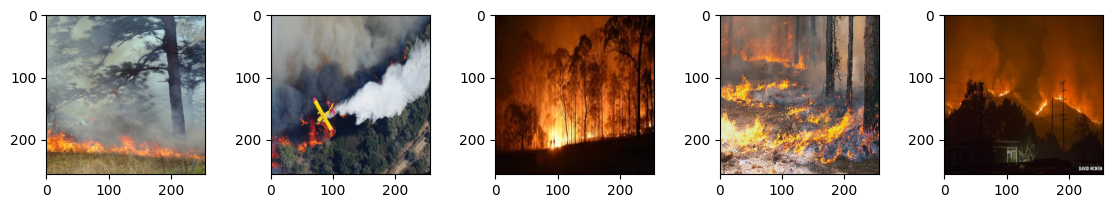

In [12]:
display_class_images(Train_data_path+'/fire/*')

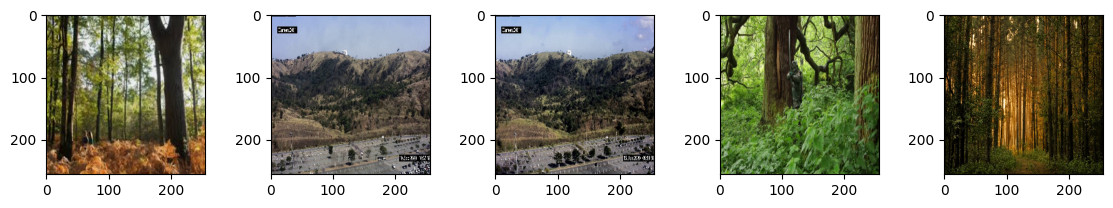

In [13]:
display_class_images(Train_data_path+'/no_fire/*')

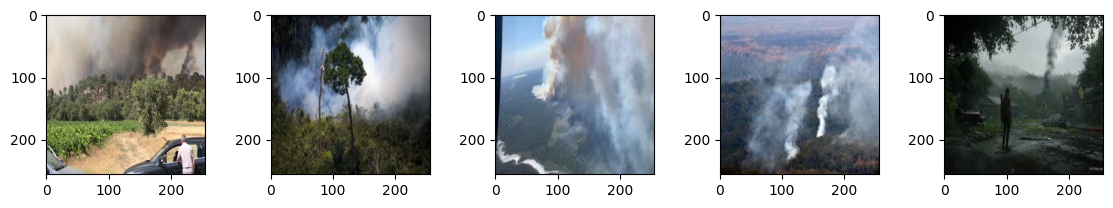

In [14]:
display_class_images(Train_data_path+'/start_fire/*')

# **7. Création des jeux de données d'entraînement, validation et test "Data Loaders"** #

In [15]:
def create_data_loaders(dataset_path, testset_path, batch_size, train_split, img_size):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(train_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[:split], indices[split:]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    test_dataset = datasets.ImageFolder(testset_path, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# **8. Définir les hyper-paramètres, EarlyStopping, Checkpoints et paramètres WandDB"** #

In [16]:
# Initialize wandb
wandb.init(project="fire-detection", config={
    "learning_rate": Learning_rate,
    "epochs": Epochs,
    "batch_size": Batch_size,
    "model": MODEL_NAME
})

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    Train_data_path, Test_data_path, Batch_size, Train_split, Img_size
)

# Initialize model
model = FireDetectionModel(MODEL_NAME, num_classes=3, learning_rate=Learning_rate)

# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename=MODEL_NAME+'_best-checkpoint',
    save_top_k=1,
    mode='min'
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)


# Initialize WandbLogger
wandb_logger = WandbLogger(project="fire-detection")

# Initialize WandbLogger
csv_logger = CSVLogger(LOG_DIR, name=MODEL_NAME, version='')

# Initialize Trainer
trainer = pl.Trainer(
    max_epochs=Epochs,
    accelerator=Accelerator,
    log_every_n_steps=1,
    devices=1,
    logger=[wandb_logger, csv_logger],
    callbacks=[checkpoint_callback, early_stop_callback],
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicolas-melaerts (nicolas-melaerts-umons). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 150MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# **9. Lancer l'entrainement (A COMPLETER)** #

In [17]:
# Train the model
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | model            | ResNet                    | 83.3 M | train
1 | criterion        | CrossEntropyLoss          | 0      | train
2 | train_accuracy   | MulticlassAccuracy        | 0      | train
3 | val_accuracy     | MulticlassAccuracy        | 0      | train
4 | test_accuracy    | MulticlassAccuracy        | 0      | train
5 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **9.1 Code permettant de chercher les meilleurs hyperparamètres avec le module Optuna** #

In [ ]:
!pip install optuna

In [ ]:
import optuna

N_TRIALS = 20

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.1, log=True)
    batch_size = trial.suggest_int('batch_size', 8, 64, log=True)
    epochs = trial.suggest_int('epochs', 1, 50)

    model = FireDetectionModel(model_name=MODEL_NAME, num_classes=num_classes, learning_rate=learning_rate)

    train_loader, val_loader, _ = create_data_loaders(
        Train_data_path, Test_data_path, batch_size, Train_split, Img_size
    )

    # Entraîner le modèle
    trainer = pl.Trainer(max_epochs=epochs, accelerator="auto", devices=1)
    trainer.fit(model, train_loader, val_loader)

    val_loss = trainer.callback_metrics["val_loss"].item()

    return val_loss

study = optuna.create_study(direction="minimize")
print("Optimisation en cours...")

for trial_number in range(1, N_TRIALS + 1):
    print(f"Essai {trial_number}/{N_TRIALS}")
    study.optimize(objective, n_trials=1)

print("Best hyperparameters:", study.best_params)


# **10. Evaluer le modèle (A COMPLETER)** ##

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/resnet152_best-checkpoint.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at checkpoints/resnet152_best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9599999785423279     │
│         test_loss         │    0.16517549753189087    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.16517549753189087, 'test_acc': 0.9599999785423279}]

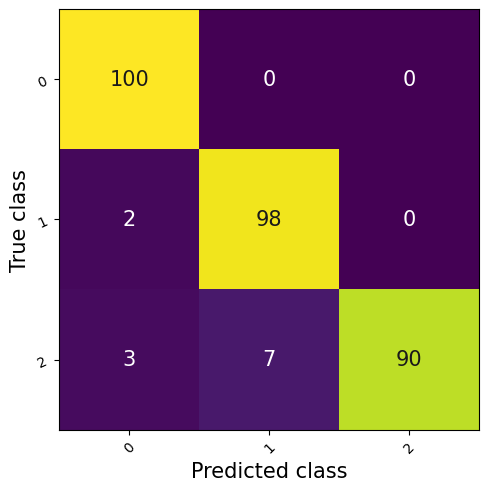

In [18]:
# Test the model
ckpt_path = 'checkpoints/' + MODEL_NAME + '_best-checkpoint.ckpt'
trainer.test(dataloaders=test_loader, ckpt_path=ckpt_path)

# **10.1 Exporter le modèle en .jit**

In [19]:
jit_model = model.to_torchscript()
torch.jit.save(jit_model, 'model_jit.pth')

# **11. Afficher les courbes d'entrainement avec la fonction "plot_metrics"** ##

In [20]:
def plot_metrics(log_folder):
  import pandas as pd
  import matplotlib.pyplot as plt

  # Load the CSV file generated by CSVLogger
  df = pd.read_csv(f'{LOG_DIR}/{log_folder}/metrics.csv')
  train_df = df[df['train_loss_epoch'].notna()]
  val_df = df[df['val_loss'].notna()]

  # Plot training loss
  plt.plot(train_df['epoch'], train_df['train_loss_epoch'], label='Train Loss')
  plt.plot(val_df['epoch'], val_df['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training & Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plot training accuracy
  plt.plot(train_df['epoch'], train_df['train_acc_epoch'], label='Train Acc')
  plt.plot(val_df['epoch'], val_df['val_acc'], label='Val Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

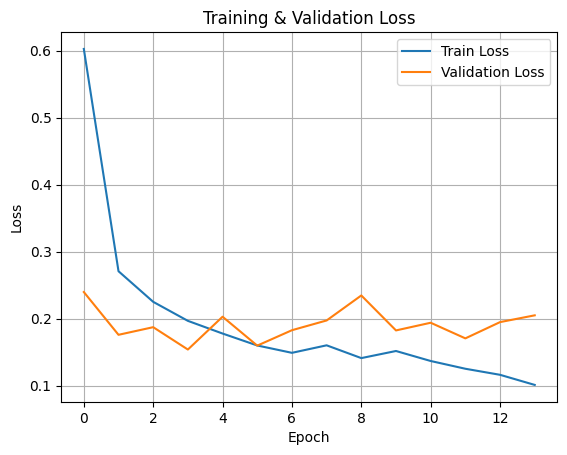

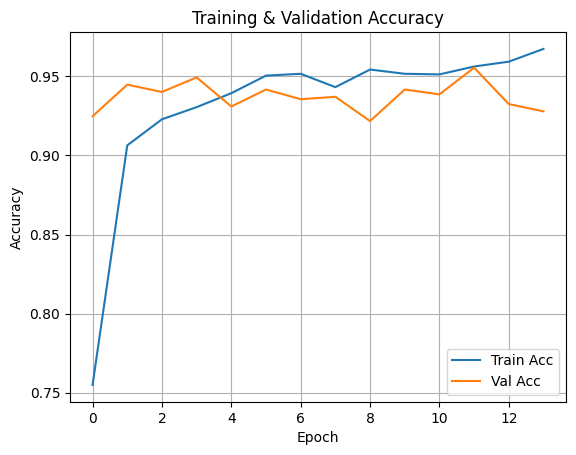

In [21]:
plot_metrics(MODEL_NAME)

# **12. Evaluation du modèle selon différentes métriques de notre librarie "Benchmark"** #

In [22]:
example_input = torch.randn(1, 3, Img_size, Img_size)
results = benchmark(model, example_input)

# log to wandb
wandb.log({
    "benchmark": results
})
wandb.finish()


/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


benchmark results
----------------------------
Number of parameters: 83.330 M
Model Size: 317.879 MiB
Number of MACs: 11.559 B

Memory Usage:
  Max memory used: 371.82 MB
  Current memory used: 343.15 MB

Performance:
  CPU: 3.07 FPS (±58.94 ms)
  GPU: 57.07 FPS (±1.39 ms)

Emissions:
  Total emissions: 0.0430 gCO2
  Total energy consumed: 0.1231 Wh
  Average emissions per inference: 0.00021503 gCO2
  Average energy consumed per inference: 0.00061574 Wh


epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▆▇▇▇▇▇▇█▇▇███
train_acc_step,▁▅▇▅▅▅▇█▇▇▇▄▅██▂▇▄████▅▅█▄▄█▇█████▇▇▇▇█▇
train_loss_epoch,█▃▃▂▂▂▂▂▂▂▁▁▁▁
train_loss_step,█▄▄▂█▂▄▃▂▄▃▃▁▃▂▁▂▃▁▂▂▂▁▃▃▂▁▁▁▁▁▁▃▂▂▂▁▂▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▂▆▅▇▃▅▄▄▁▅▅█▃▂
val_loss,█▃▄▁▅▁▃▅█▃▄▂▄▅
epoch,14


# **13. Tester le modèle avec une image de test de votre choix (A COMPLETER)"**

Class Name: fire --- Class Probability: 99.71%
Class Name: no fire --- Class Probability: 0.19%
Class Name: start fire --- Class Probability: 0.10%


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


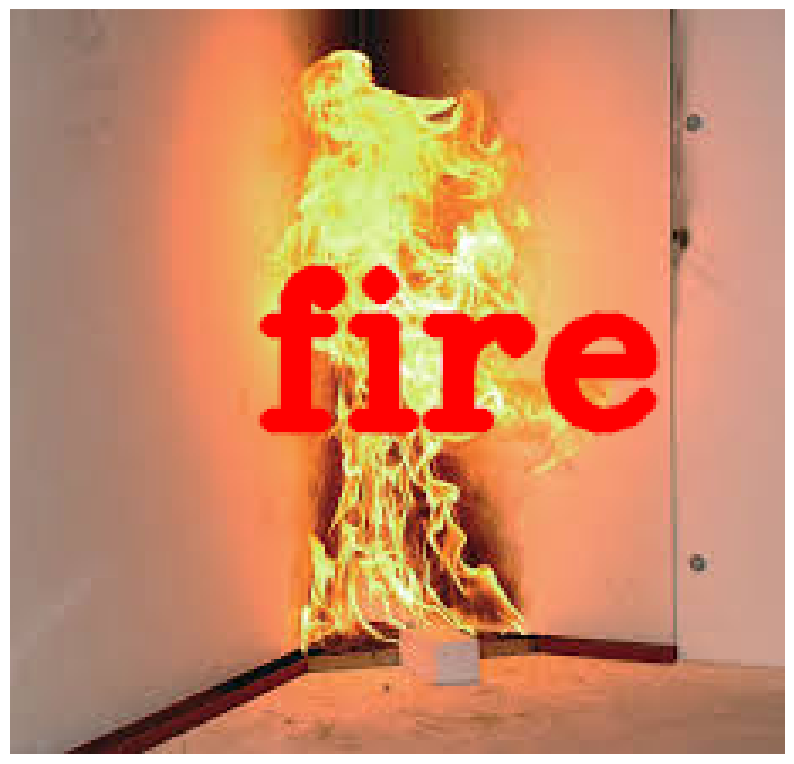

In [24]:
image_path = "img.jpg"

classes = ["fire", "no fire", "start fire"]

# Load and preprocess the image
img = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((Img_size, Img_size)),
    transforms.ToTensor(),
])
x = transform(img).unsqueeze(0).to("cuda")  # Add batch dimension

# Predict
model.eval()
with torch.no_grad():
    pred = model(x)
    probabilities = torch.nn.functional.softmax(pred[0], dim=0)

# Display results
plt.figure(figsize=(10, 10))
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for pos, prob in enumerate(probabilities):
    class_name = classes[pos]
    print(f"Class Name: {class_name} --- Class Probability: {prob.item()*100:.2f}%")

    if pos == torch.argmax(probabilities).item():
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) // 2
        textY = (img.shape[0] + textsize[1]) // 2
        cv2.putText(img, class_name, (textX-10, textY), font, 2, (255,0,0), 6, cv2.LINE_AA)

plt.imshow(img)
plt.axis('off')
plt.show()

# **QUESTION : APRES avoir complété et testé le code plus haut, analyser les résultats et proposer le meilleur modèle, données et hyper-paramètres pouvant répondre aux éxigences du défi 1 (voir l'énoncé)"**

Notre meilleur modèle est Resnet152, il a été entraîner avec des batch de taille 16, 20 epochs et un learning rate de 0.01.
La base de données utilisé est une combinaison des différentes base de données avec des techniques de data augmentation et data réduction comme expliquer dans le rapport.

Nous avons fournis le code Optuna qui nous as servi à trouver de bons hyperparamètres pour chaque modèle mais peu précis à cause des limitations Google colab qui ne permette pas de run une cellule plus d'une heure.